# PISA Loan Data Exploration 
## by Adiji Ayomiposi

## Introduction
This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.

But the features I wil base my analysis on are:

- **ListingCreationDate**: The date the listing(request for the loan) was created.

- **BorrowerAPR**: The Borrower's Annual Percentage Rate (APR) for the loan.

- **ProsperRating (Alpha)**: The Prosper Rating assigned at the time the listing was created between AA - HR. Applicable for loans originated after July 2009.

- **ProsperScore**: A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score.  Applicable for loans originated after July 2009.

- **ListingCategory (numeric)**: The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans

- **Occupation**: The Occupation selected by the Borrower at the time they created the listing.

- **IsBorrowerHomeowner**: A Borrower will be classified as a homowner if they have a mortgage on their credit profile or provide documentation confirming they are a homeowner.

- **CreditScoreRangeLower**: The lower value representing the range of the borrower's credit score as provided by a consumer credit rating agency.

- **CreditScoreRangeUpper**: The upper value representing the range of the borrower's credit score as provided by a consumer credit rating agency. 

- **DebtToIncomeRatio**: The debt to income ratio of the borrower at the time the credit profile was pulled. This value is Null if the debt to income ratio is not available. This value is capped at 10.01 (any debt to income ratio larger than 1000% will be returned as 1001%).

- **IncomeRange**: The yearly income range of the borrower at the time the listing was created.

- **IncomeVerifiable**: The borrower indicated they have the required documentation to support their income.

- **StatedMonthlyIncome**: The monthly income the borrower stated at the time the listing was created.

- **LoanMonthsSinceOrigination**: Number of months since the loan originated.

- **LoanOriginalAmount**: The origination amount of the loan.

- **MonthlyLoanPayment**: The scheduled monthly loan payment.

- **Investors**: The number of investors that funded the loan.


## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

sns.set(style='darkgrid')

%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe, print first 5 rows and summary using info method

pisa = pd.read_csv('prosperLoanData.csv')
print(pisa.head())
print(pisa.info())

                ListingKey  ListingNumber            ListingCreationDate  \
0  1021339766868145413AB3B         193129  2007-08-26 19:09:29.263000000   
1  10273602499503308B223C1        1209647  2014-02-27 08:28:07.900000000   
2  0EE9337825851032864889A          81716  2007-01-05 15:00:47.090000000   
3  0EF5356002482715299901A         658116  2012-10-22 11:02:35.010000000   
4  0F023589499656230C5E3E2         909464  2013-09-14 18:38:39.097000000   

  CreditGrade  Term LoanStatus           ClosedDate  BorrowerAPR  \
0           C    36  Completed  2009-08-14 00:00:00      0.16516   
1         NaN    36    Current                  NaN      0.12016   
2          HR    36  Completed  2009-12-17 00:00:00      0.28269   
3         NaN    36    Current                  NaN      0.12528   
4         NaN    36    Current                  NaN      0.24614   

   BorrowerRate  LenderYield  ...  LP_ServiceFees  LP_CollectionFees  \
0        0.1580       0.1380  ...         -133.18             

The prosper dataset has 113937 records, and not entirely clean, I will quickly take only a portion of this.

And also it has 80 columns but I will take out the columns of interest

In [3]:
# cretaing a copy of the dataframe to work on
clean_pisa = pisa.loc[:,:]

In [4]:
# change the datatype of ListingCreationDate and LoanOriginationDate to datetime
for column in ['ListingCreationDate', 'LoanOriginationDate']:
    clean_pisa[column] = pd.to_datetime(clean_pisa[column])
    clean_pisa[column] = clean_pisa[column].dt.normalize()

# accesing only records after July 2009 of listing to ensure all prosper data is available
clean_pisa = clean_pisa[clean_pisa['ListingCreationDate'] >= '2009-07-01']

# check to ensure minimum date is July 2009
clean_pisa['ListingCreationDate'].min()

Timestamp('2009-07-13 00:00:00')

In [5]:
# droppping null in the Occupation, EmploymentStatusDuration, and DebtToIncomeRatio columns

# creating function to help in dropping nulls
def subset_notna(data, column):
    """
    Subsetting datasets to filter records in particular columns that is not null
    """
    data = data[data[column].notna()]

    return data


columns = ['Occupation', 'DebtToIncomeRatio', 'EmploymentStatusDuration']
for column in columns:
    clean_pisa = subset_notna(data=clean_pisa, column=column)

# check to ensure that there are no null values for these columns    
clean_pisa[columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76216 entries, 1 to 113936
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Occupation                76216 non-null  object 
 1   DebtToIncomeRatio         76216 non-null  float64
 2   EmploymentStatusDuration  76216 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.3+ MB


In [6]:
# load a dataset containing columns names and description
# status if null means i do not require those columns

columns_needed = pd.read_csv('columns.csv')
columns_needed.head()

,Variable,Description,Status
0,ListingKey,"Unique key for each listing, same value as the...",NaN
1,ListingNumber,The number that uniquely identifies the listin...,NaN
2,ListingCreationDate,The date the listing was created.,1
3,CreditGrade,The Credit rating that was assigned at the tim...,NaN
4,Term,The length of the loan expressed in months.,NaN


In [7]:
columns_needed.iloc[10:20,:]

,Variable,Description,Status
10,EstimatedEffectiveYield,Effective yield is equal to the borrower inter...,NaN
11,EstimatedLoss,Estimated loss is the estimated principal loss...,NaN
12,EstimatedReturn,The estimated return assigned to the listing a...,NaN
13,ProsperRating (numeric),The Prosper Rating assigned at the time the l...,NaN
14,ProsperRating (Alpha),The Prosper Rating assigned at the time the li...,1
15,ProsperScore,A custom risk score built using historical Pro...,1
16,ListingCategory (numeric),The category of the listing that the borrower ...,1
17,BorrowerState,The two letter abbreviation of the state of th...,NaN
18,Occupation,The Occupation selected by the Borrower at the...,1
19,EmploymentStatus,The employment status of the borrower at the t...,NaN


In [8]:
# subsetting clean_pisa to select the columns required

columns_needed = columns_needed[columns_needed.Status.notna()]
columns_needed_list = list(columns_needed.Variable)

clean_pisa = clean_pisa.loc[:, columns_needed_list]
print(len(clean_pisa.columns))
clean_pisa.columns

16


Index(['ListingCreationDate', 'BorrowerAPR', 'ProsperRating (Alpha)',
       'ProsperScore', 'ListingCategory (numeric)', 'Occupation',
       'IsBorrowerHomeowner', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable',
       'StatedMonthlyIncome', 'LoanOriginalAmount', 'MonthlyLoanPayment',
       'Investors'],
      dtype='object')

In [9]:
clean_pisa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76216 entries, 1 to 113936
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ListingCreationDate        76216 non-null  datetime64[ns]
 1   BorrowerAPR                76216 non-null  float64       
 2   ProsperRating (Alpha)      76216 non-null  object        
 3   ProsperScore               76216 non-null  float64       
 4   ListingCategory (numeric)  76216 non-null  int64         
 5   Occupation                 76216 non-null  object        
 6   IsBorrowerHomeowner        76216 non-null  bool          
 7   CreditScoreRangeLower      76216 non-null  float64       
 8   CreditScoreRangeUpper      76216 non-null  float64       
 9   DebtToIncomeRatio          76216 non-null  float64       
 10  IncomeRange                76216 non-null  object        
 11  IncomeVerifiable           76216 non-null  bool          
 12  Sta

In [10]:
# Occupation some jobs were split into different types but I'll join them for the sake of this analysis

for occupation in ['Student', 'Engineer', 'Tradesman', 'Sales', 'Nurse']:
    clean_pisa.loc[clean_pisa['Occupation'].str.contains(occupation),'Occupation'] = occupation

    
clean_pisa['Occupation'] = clean_pisa['Occupation'].astype('category')
# check if the occupations are merged under new name
clean_pisa['Occupation'].unique()

['Professional', 'Skilled Labor', 'Executive', 'Sales', 'Laborer', ..., 'Biologist', 'Judge', 'Car Dealer', 'Landscaping', 'Homemaker']
Length: 53
Categories (53, object): ['Accountant/CPA', 'Administrative Assistant', 'Analyst', 'Architect', ..., 'Teacher's Aide', 'Tradesman', 'Truck Driver', 'Waiter/Waitress']

In [11]:
# convert ProsperRating (Alpha) and IncomeRange into ordered categorical types
ordinal_var_dict = {'ProsperRating (Alpha)': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
                    'IncomeRange': ['Not employed',
                                    '$1-24,999',
                                    '$25,000-49,999',
                                    '$50,000-74,999',
                                    '$75,000-99,999',
                                    '$100,000+']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    clean_pisa[var] = clean_pisa[var].astype(ordered_var)
    
# convert Occupation, BorrowerState to category
# clean_pisa['Occupation'] = clean_pisa['Occupation'].astype(category)
# clean_pisa['BorrowerState'] = clean_pisa['BorrowerState'].astype(category)

clean_pisa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76216 entries, 1 to 113936
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ListingCreationDate        76216 non-null  datetime64[ns]
 1   BorrowerAPR                76216 non-null  float64       
 2   ProsperRating (Alpha)      76216 non-null  category      
 3   ProsperScore               76216 non-null  float64       
 4   ListingCategory (numeric)  76216 non-null  int64         
 5   Occupation                 76216 non-null  category      
 6   IsBorrowerHomeowner        76216 non-null  bool          
 7   CreditScoreRangeLower      76216 non-null  float64       
 8   CreditScoreRangeUpper      76216 non-null  float64       
 9   DebtToIncomeRatio          76216 non-null  float64       
 10  IncomeRange                76216 non-null  category      
 11  IncomeVerifiable           76216 non-null  bool          
 12  Sta

In [12]:
# to ensure more accurate data, I will only use records with verified income
clean_pisa = clean_pisa.query('IncomeVerifiable')
clean_pisa.drop(columns='IncomeVerifiable', inplace=True)

In [13]:
# Ensuring understanding if listing category

# Create a dictionary containing the categories meaning
ListingCat_dict ={0:'Not Available', 1:'Debt Consolidation', 2:'Home Improvement', 3:'Business', 
      4:'Personal Loan', 5:'Student Use', 6:'Auto', 7:'Other', 8:'Baby&Adoption', 
      9:'Boat', 10:'Cosmetic Procedure', 11:'Engagement Ring', 12:'Green Loans', 
      13:'Household Expenses', 14:'Large Purchases', 15:'Medical/Dental', 
      16:'Motorcycle', 17:'RV', 18:'Taxes', 19:'Vacation', 20:'Wedding Loans'}

# use this category to change the Listing category to display what each integer means and add it to the dataframe
ListingCat = []

for row, column in clean_pisa.iterrows():
    ListingCat.append(ListingCat_dict[clean_pisa.loc[row,'ListingCategory (numeric)']])
    
clean_pisa['ListingCategory'] = ListingCat
clean_pisa.drop(columns='ListingCategory (numeric)', inplace=True)
clean_pisa['ListingCategory'] = clean_pisa['ListingCategory'].astype("category")

# cheack that the changes were made successfully
clean_pisa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76168 entries, 1 to 113936
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ListingCreationDate    76168 non-null  datetime64[ns]
 1   BorrowerAPR            76168 non-null  float64       
 2   ProsperRating (Alpha)  76168 non-null  category      
 3   ProsperScore           76168 non-null  float64       
 4   Occupation             76168 non-null  category      
 5   IsBorrowerHomeowner    76168 non-null  bool          
 6   CreditScoreRangeLower  76168 non-null  float64       
 7   CreditScoreRangeUpper  76168 non-null  float64       
 8   DebtToIncomeRatio      76168 non-null  float64       
 9   IncomeRange            76168 non-null  category      
 10  StatedMonthlyIncome    76168 non-null  float64       
 11  LoanOriginalAmount     76168 non-null  int64         
 12  MonthlyLoanPayment     76168 non-null  float64       
 13  

In [14]:
# get the average Credit score and delete the features used to engineer it
clean_pisa['CreditScoreAverage'] = (clean_pisa['CreditScoreRangeLower'] + clean_pisa['CreditScoreRangeUpper'])/2
clean_pisa.drop(columns=['CreditScoreRangeUpper', 'CreditScoreRangeLower'], inplace=True)

# check that the new features are added and the parent feature dropped
clean_pisa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76168 entries, 1 to 113936
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ListingCreationDate    76168 non-null  datetime64[ns]
 1   BorrowerAPR            76168 non-null  float64       
 2   ProsperRating (Alpha)  76168 non-null  category      
 3   ProsperScore           76168 non-null  float64       
 4   Occupation             76168 non-null  category      
 5   IsBorrowerHomeowner    76168 non-null  bool          
 6   DebtToIncomeRatio      76168 non-null  float64       
 7   IncomeRange            76168 non-null  category      
 8   StatedMonthlyIncome    76168 non-null  float64       
 9   LoanOriginalAmount     76168 non-null  int64         
 10  MonthlyLoanPayment     76168 non-null  float64       
 11  Investors              76168 non-null  int64         
 12  ListingCategory        76168 non-null  category      
 13  

In [15]:
clean_pisa.describe()

,BorrowerAPR,ProsperScore,DebtToIncomeRatio,StatedMonthlyIncome,LoanOriginalAmount,MonthlyLoanPayment,Investors,CreditScoreAverage
count,76168.000000,76168.000000,76168.000000,76168.000000,76168.000000,76168.000000,76168.000000,76168.000000
mean,0.223893,6.081557,0.257865,6002.522318,9295.782678,296.442123,70.029277,708.781588
std,0.079380,2.360344,0.318710,5109.187734,6414.361230,189.702315,97.817198,47.287594
min,0.045830,1.000000,0.000000,0.250000,1000.000000,0.000000,1.000000,609.500000
25%,0.161570,4.000000,0.150000,3583.333333,4000.000000,159.040000,1.000000,669.500000
50%,0.215660,6.000000,0.220000,5041.666667,8000.000000,257.760000,32.000000,709.500000
75%,0.287800,8.000000,0.320000,7250.000000,14667.000000,392.515000,100.000000,729.500000
max,0.423950,11.000000,10.010000,483333.333333,35000.000000,2251.510000,1189.000000,889.500000


### What is the structure of your dataset?

There are 76,168 reords of people in the dataset with 14 features. Most variables are numeric in nature, but the variables ProsperRating (Alpha) and IncomeRange are ordered factor variables with the following levels.

(least) ——> (best) <br>
ProsperRating (Alpha): HR, E, D, C, B, A, AA <br>
IncomeRange: Not employed, $1-24,999, $25,000-49,999, $50,000-74,999, $75,000-99,999, $100,000+

Is Borrower Homeowner is boolean datatype

The Listing category and occupation are unordered category types

The Listing Creation Date is in datetime datatype

### What is/are the main feature(s) of interest in your dataset?

I am most interested in finding out what features affect the Borrower APR (Annual Rate).

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I believe the homeowner feature will be of help, the income range and monthly income should also assisst the investigation.

## Univariate Exploration

In this section, I will investigate distributions of individual variables to see where we need to look at relationships between variables.


In [16]:
# defining a countplot functtion to be reused

default_color = sns.color_palette()[0]

def mylabels(title, x_label, y_label):
    """
    Format for title and labels
    """
    # title formatting
    plt.title(title.title(), fontsize=14, weight='bold')
    
    # label formatting
    plt.xlabel(x_label.title(), fontsize=12, weight='bold')
    
    plt.ylabel(y_label.title(), fontsize=12, weight='bold')

def myCountPlot(df, xVar, xname=None,**kwargs):
    """
    For plottting countplots throughout this exploration
    """
    # plot
    sns.countplot(data=df, x=xVar, color=default_color, **kwargs)
    
    # add title and lables
    
    if xname:
        mylabels(f'Distribution of {xname}', xname, 'Frequency')
    else:
        mylabels(f'Distribution of {xVar}', xVar, 'Frequency')
        
def myViolinplot(df, xVar, yVar, xname=None, yname=None, **kwargs):
    """
    For plotting violin plots
    """
    # plot
    sns.violinplot(data=df, x=xVar, y=yVar, color=default_color, inner='quartile')

    # add title and lables
    
    # format for title
    
    if (xname.endswith(")")):
        xtitle = xname[:-4]
    else:
        xtitle = xname
    
    if (yname.endswith(")")):
        ytitle = yname[:-4]
    else:
        ytitle = yname
        
    if xname and yname:
        mylabels(f'{ytitle} vs {xtitle}', xname, yname)
    else:
        mylabels(f'Violinplot of {xVar} and {yVar}', xVar, yVar)

Let's start with the features most in question:

What will be the distribution of the rate?

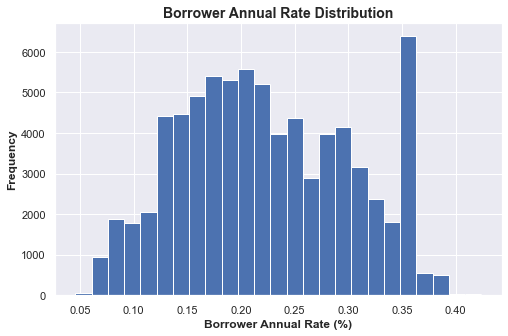

In [17]:
plt.figure(figsize=[8, 5])
plt.hist(data = clean_pisa, x = 'BorrowerAPR', bins=25)
mylabels('Borrower Annual Rate Distribution','Borrower Annual Rate (%)', 'Frequency')
plt.show()

The histogram is bimodal, the first peak at around 0.20, but there's a break in the decline at around 0.25-0.27, and a sharp increase between 0.35 and 0.37.

Next up the independent features:

Starting with the boolean (i.e the yes or no) columns: Is Home Owner

Do we have more homeowners in the dataset?

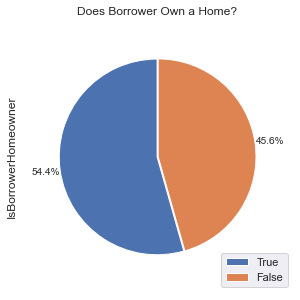

In [18]:
# create size for plot
plt.figure(figsize=[18, 5])

# create function for plotting pie chart
def custom_pie(data,pctdistance=1.1,colors=['C0', 'C1']):
    labels = ['True', 'False']
    colours = {'True': 'C0',
           'False': 'C1'}
    data.value_counts().plot(kind='pie', 
                             autopct='%1.1f%%', 
                             explode=(0, 0.01), 
                             labeldistance=None, 
                             radius=0.9, 
                             startangle=90, 
                             pctdistance=pctdistance, 
                             colors=colors)

custom_pie(data=clean_pisa['IsBorrowerHomeowner'], pctdistance=1.15)
plt.title('Does Borrower Own a Home?')
plt.legend();

The distribution of houseownership is fairly even, 54.4 % have mortgages. We see to have more home owners in this dataset

Next the time data: ListingCreationDate

Which times are the most loans requested?

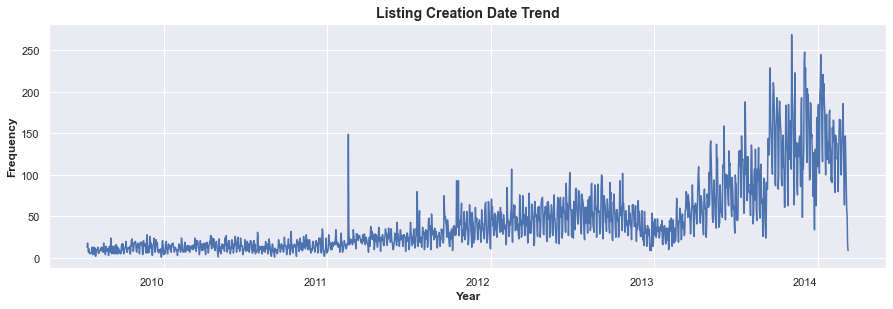

In [19]:
plt.figure(figsize=[15, 5])

clean_pisa['ListingCreationDate'].value_counts().plot(kind='line')
plt.xticks(rotation=0)
mylabels('Listing Creation Date Trend','Year', 'Frequency')

The listing creation date and loan origination date distribution is seen to gradually increase as the years proceed, but interestingly there's a spike at the beginning of 2011 of the listing creation date.

This spike shows that more people applied for loan at the beginning of 2011, but they were not granted till later.

Checking Financial status: Occupation, Income, Income Range, Employment Status, and Employment Duration

Which occupation is the most represented in the datset?

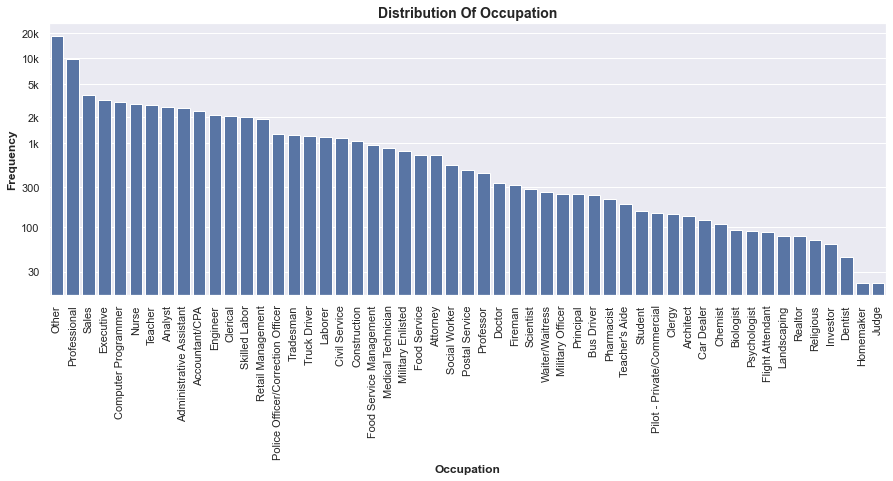

In [20]:
plt.figure(figsize=[15, 5])

myCountPlot(clean_pisa, 'Occupation', order = clean_pisa['Occupation'].value_counts().index)
plt.xticks(rotation=90)
plt.yscale('log')
plt.yticks([30, 100, 300, 1e3, 2e3, 5e3, 1e4, 2e4], [30, 100, 300, '1k', '2k', '5k', '10k', '20k']);

Setting the count scale to log we can that the most accounted occupation is Professional, the leading numbers are those under others.
The occupation with the least loan takers are Judges and Homemakers with less than 30 of them in the loan dataset.

I'm going to look into the income to see if anything can be gathered:

What is the distribution of the monthly income of records in this dataset?

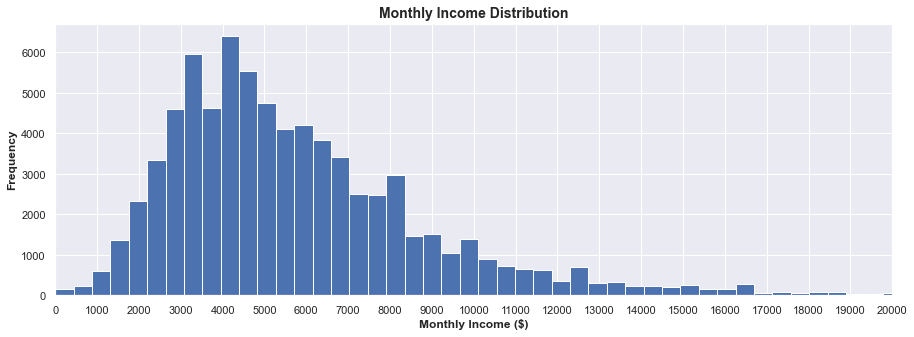

In [21]:
# making some changes to the plot, limiting the x-axis, and increasing the bins
plt.figure(figsize=[15, 5])

bins=bins = np.arange(0.25, 20000+1000, 1000)
clean_pisa['StatedMonthlyIncome'].plot(kind='hist', bins=1100)
plt.xlim(0,20000)
plt.xticks(bins, label=bins)
mylabels('Monthly Income Distribution','Monthly Income ($)', 'Frequency');

After limiting the stated monthly income to 20000, the distribution is unimodal with the peak falling between 40 000 to 45 000, the distributionis also right-skewed with the mean larger than the mode.

Supporting the plot is the income range:

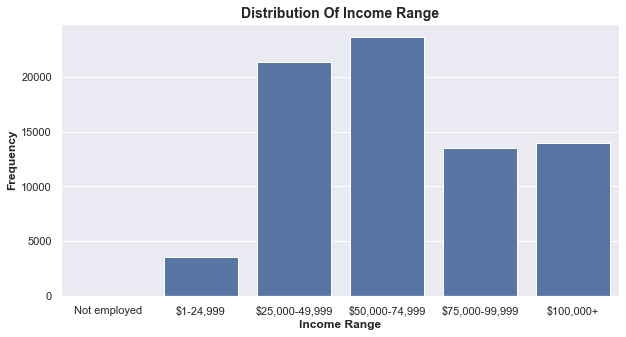

In [22]:
plt.figure(figsize=[10, 5])
myCountPlot(clean_pisa, 'IncomeRange', xname='Income Range')

Checking to debt to income ratio:

What is the distibution of the debt to income ratio?

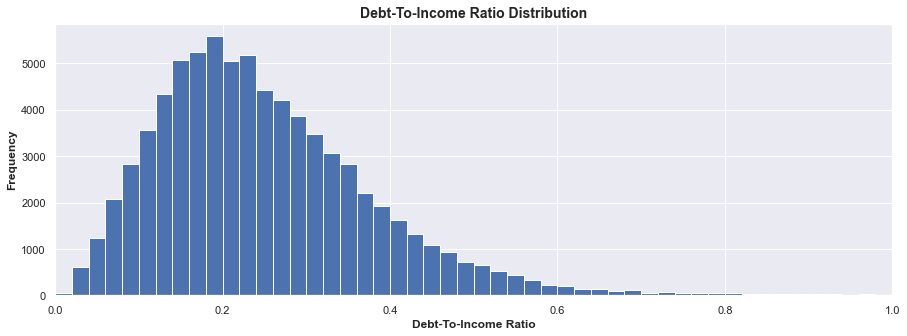

In [23]:
clean_pisa['DebtToIncomeRatio'].describe()

plt.figure(figsize=[15, 5])

bins=bins = np.arange(0, 10.01+0.02, 0.02)
clean_pisa['DebtToIncomeRatio'].plot(kind='hist', bins=bins)
plt.xlim(0,1)
mylabels('Debt-to-income ratio distribution','Debt-to-Income ratio', 'Frequency');

After limiting the ration to 1, the data is uniformly distributed, peaking at 0.2.
Most of the data is below 1 so the debt for most is less than their income.

Checking the Credit score distribution:

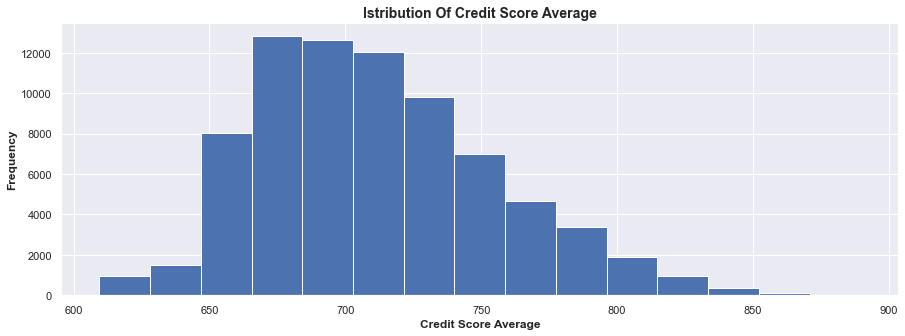

In [24]:
plt.figure(figsize=[15, 5])

# bins=bins = np.arange(0.25, 20000+1000, 1000)
clean_pisa['CreditScoreAverage'].plot(kind='hist', bins=15)
# plt.xlim(0,20000)
# plt.xticks(bins, label=bins)
mylabels('istribution of Credit Score Average','Credit Score Average', 'Frequency');

 A unimodal distribution, right-skewed, shows that most of the rating averges falls between 650 and 750
 
 Checking the Prosper ratings  and score next:


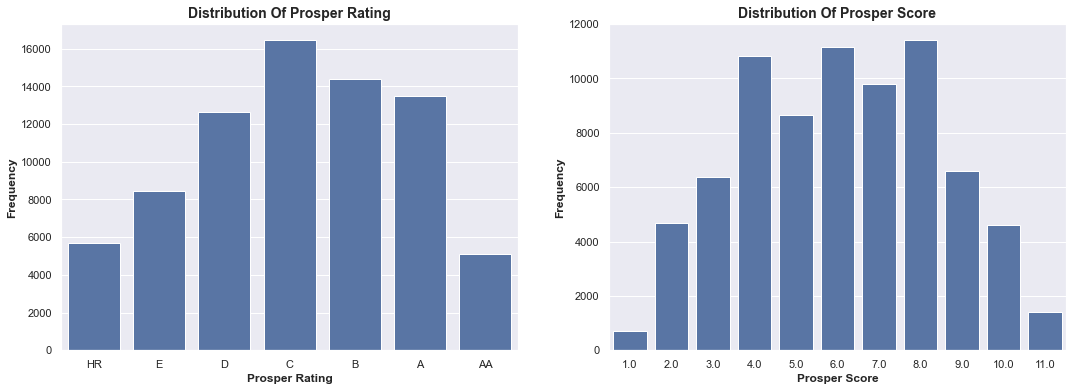

In [25]:
# create size for plots
plt.figure(figsize=[18, 6])

plt.subplot(1, 2, 1)
myCountPlot(clean_pisa, 'ProsperRating (Alpha)', xname='prosper rating')

plt.subplot(1, 2, 2)
myCountPlot(clean_pisa, 'ProsperScore', xname='prosper score');

Prosper Score and Rating look very uniform with the most poiints at the centre. Most ratings are between D and A. Most scores are between 4 and 8.

Let's check the properties of Loans: Loan Amount and Amount to be paid back, 

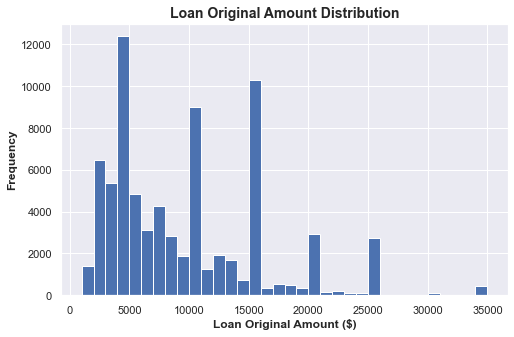

In [26]:
plt.figure(figsize=[8, 5])

bins= np.arange(clean_pisa.LoanOriginalAmount.min(), clean_pisa.LoanOriginalAmount.max()+1000, 1000)
plt.hist(data = clean_pisa, x = 'LoanOriginalAmount', bins=bins)
mylabels('Loan Original Amount Distribution','Loan Original Amount ($)', 'Frequency')
plt.show()

The spikes are at 5000 intervals (e.g 5 000, 10 000, 15 000, ...etc), I guess most people collect loans at that regular amount.

With most of the loans less than 25 000.

Next Monthly Loan Payment:

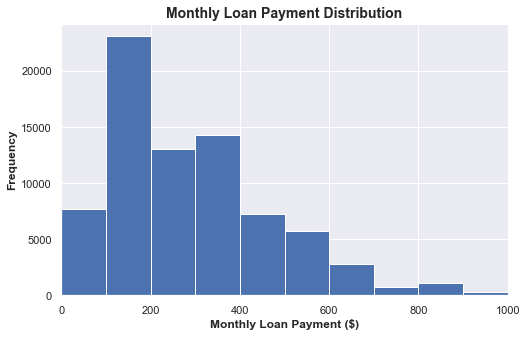

In [27]:
plt.figure(figsize=[8, 5])

bins= np.arange(clean_pisa.MonthlyLoanPayment.min(), clean_pisa.MonthlyLoanPayment.max()+100, 100)
plt.hist(data = clean_pisa, x = 'MonthlyLoanPayment', bins=bins)
plt.xlabel('Monthly Loan Payment ($)')
mylabels('Monthly Loan Payment Distribution','Monthly Loan Payment ($)', 'Frequency')

# zooming into the 0 - 1000 as that is where most data are
plt.xlim(0, 1000);

Most of the monthly loan payment are less than $1000

The distribution below the 1000 mark is unimodal, peaking at $200

Checking the investors:

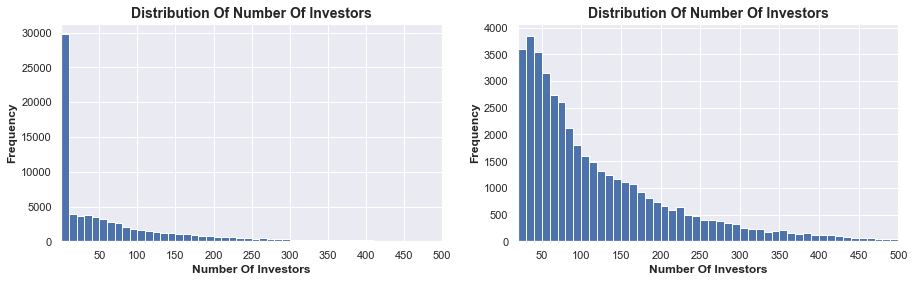

In [28]:
plt.figure(figsize=[15, 4])

plt.subplot(1, 2, 1)
bins = np.arange(0, 510, 10)
clean_pisa['Investors'].plot(kind='hist', bins=bins)
plt.xlim(0,500)

ticks = np.arange(50, 550, 50)
plt.xticks(ticks, ticks)
mylabels('Distribution of number of investors','Number of Investors', 'Frequency')

plt.subplot(1, 2, 2)
bins = np.arange(10, 510, 10)
clean_pisa['Investors'].plot(kind='hist', bins=bins)
plt.xlim(20,500)

ticks = np.arange(50, 550, 50)
plt.xticks(ticks, ticks)
mylabels('Distribution of number of investors','Number of Investors', 'Frequency');

There's a lot of persons with less than 10 investors, zooming into ivestors greater than 10, we see it more clearly theres a obvious drop in the frequency of number of investors.

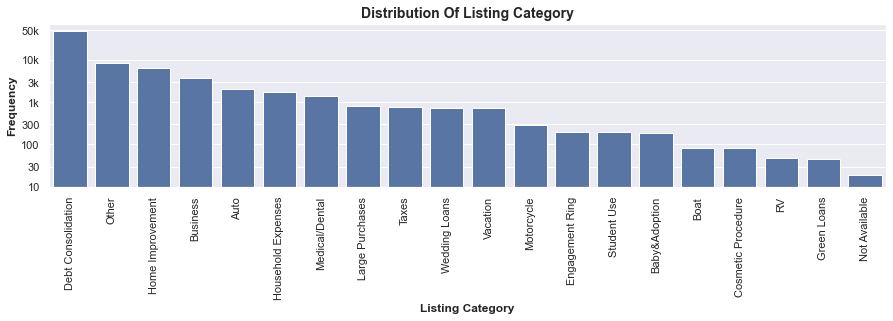

In [29]:
plt.figure(figsize=[15, 3])
myCountPlot(clean_pisa, 'ListingCategory', xname='Listing category',
            order = clean_pisa['ListingCategory'].value_counts().index)

plt.xticks(rotation=90)
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1e3, 3e3, 1e4, 5e4], [10, 30, 100, 300, '1k', '3k', '10k', '50k'])
plt.show()

Looks like most people collect loans just to pay off debts, wow. The least collected loans are Green loans.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

## Interest

- Borrower APR - Asides the large number of those with 0.35% rate the distribution is fairly uniform, would have to compare it with other features to get more details.

### Independent
- Home Owners -  nothing too interesting here, most laon takers are home owners, not surprising home owners have lesser risk on loans


- Listing Creation Date - Increase in the amount of listings as date increases.


- Occupation - too many categories. Most persons job are not known, but the job with most number of loan takers most are Professionals. The least loan takers are Judges and Homemakers.
I had to do a log transformation on the count scale to see the other categories well


- Monthly Income - I had to limit the income to 20 000 as there was an outlier of 483 000. Most income falls between 40 000 to 45 000


- Income Range - Used it to support the monthly income, helps reinforce the idea but counter intuitive because the highest range was 50000 - 74 999


- Debt to Income Ratio - Highest being 10.01, but most of the data fell in 0 - 1 so limited it to 0 - 1. The mode of the distribution was around 0.2


- Credit scrore Average - An engineered feature, a uniform distribution peak at 700


- Prosper Score and Prosper Rating - Didn't know which would be more efficient, but prosper rating is assigned as listing os 
created while the score is based on previous data


- Original Amount of Loan - Peaks at 5000 intervals, I guess people don't like taking loans of 22000.


- Monthly Loan Payment - Limited the plot to $ 1000, uniform distribution, most people would pay 200 monthly.


- Investors - Limiting the number of investors from 20 to 300, we see that it is a steady decline from 20 till 300.


- Listing Category - Most loans are debt consolidation and the least are Green loans.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Listing Category - I changed it from the numeric category as it wasn't easy to understand, to the text explanations


Occupation - Some occupations were split e.g Student, Nurse, Enginering, but i joined them under their collective root job to reduce the amount of catgories and get a more general view.


Credit Score - had two variables (Upper and Lower), I engineered an average score to create a new columns so analysis van easily be done

## Bivariate Exploration

Starting with a heatmap of the ocrrelation between  numeric features

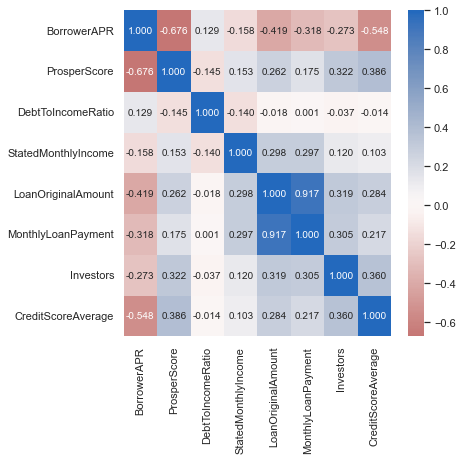

In [30]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

clean_pisa.select_dtypes(include=numerics)

plt.figure(figsize = [6,6])
sns.heatmap(clean_pisa.select_dtypes(include=numerics).corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

The Prosper Score, Loan amount, Monthly loan Payment and credit score average are highly negatively correlated with the BorrowerAPR.

The loan payment and the loand amount are also positively correlated, obviously, it is what you take as loan that would dictat how you pay back.

pisa shape= (76168, 14)
pisa_samp shape= (500, 14)


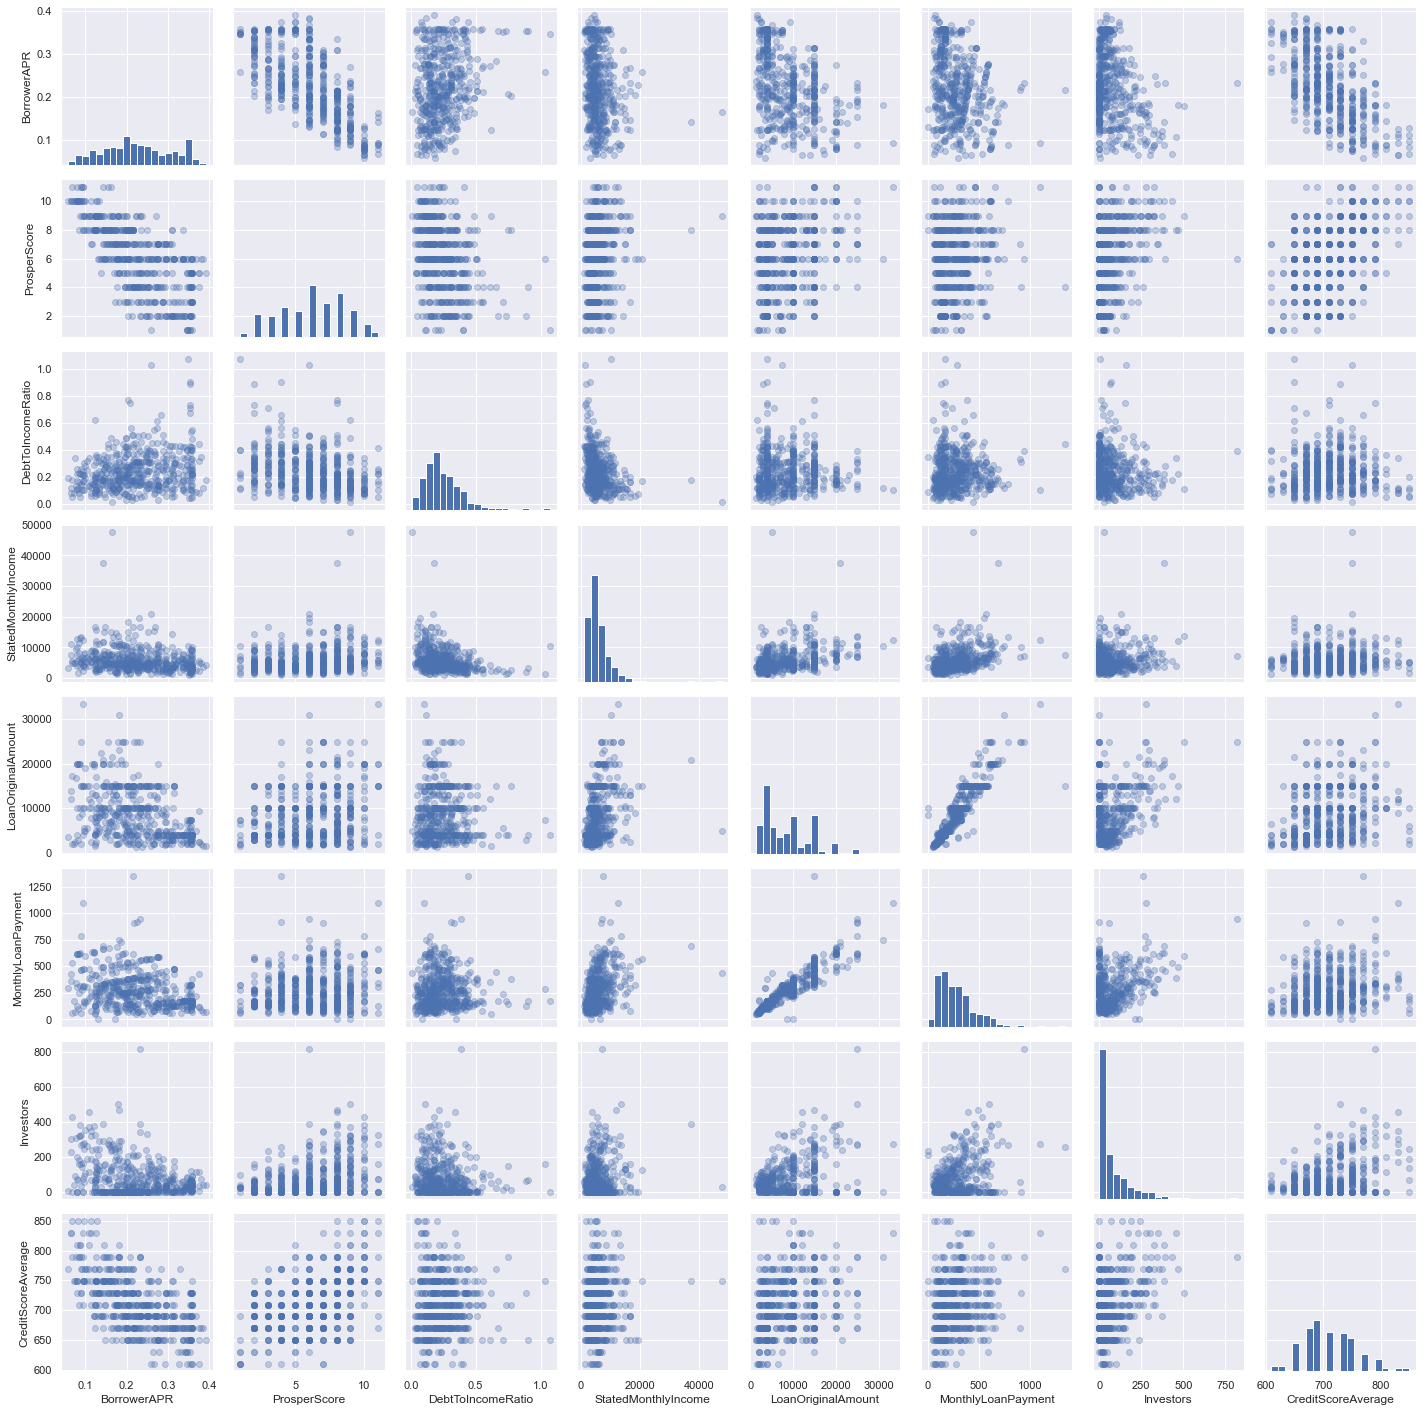

In [31]:
print("pisa shape=",clean_pisa.shape)
clean_pisa_samp = clean_pisa.sample(n=500, replace = False, random_state=1)
print("pisa_samp shape=",clean_pisa_samp.shape)

g = sns.PairGrid(data = clean_pisa_samp.select_dtypes(include=numerics))
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter, alpha=0.3)

From the heatmap and the PairGrid, we can see the Prosper Score, Debt to Income Ratio, the Original Loan Amount and Credit Score average seem to have strong correlations with Borrower APR. We will delve deeper

### Prosper Rating and Score  

How does the Prosper Score and rating correlate with the Borrower Annual Rate?

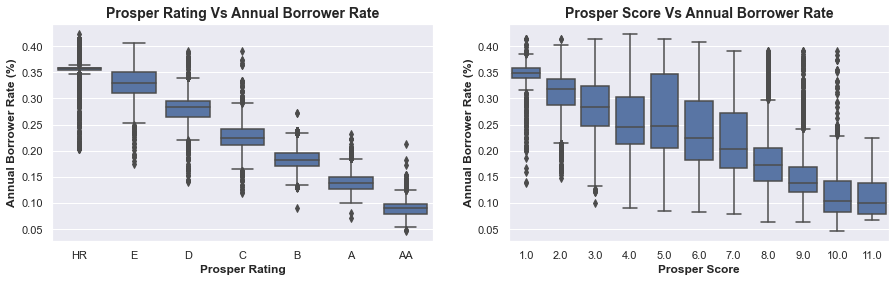

In [32]:
plt.figure(figsize=[15, 4])

plt.subplot(1, 2, 1)
sns.boxplot(data=clean_pisa, x='ProsperRating (Alpha)', y='BorrowerAPR', color=default_color)
mylabels('prosper rating vs Annual Borrower rate','prosper rating', 'Annual Borrower Rate (%)');

plt.subplot(1, 2, 2)
sns.boxplot(data=clean_pisa, x='ProsperScore', y='BorrowerAPR', color=default_color)
mylabels('prosper score vs Annual Borrower rate','prosper score', 'Annual Borrower Rate (%)');

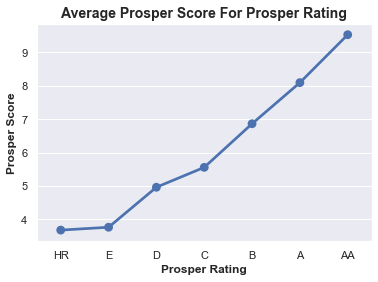

In [33]:
sns.pointplot(data=clean_pisa, y='ProsperScore', x='ProsperRating (Alpha)', dodge=0.5)
mylabels('average prosper score for prosper rating','prosper rating', 'Prosper Score');

The Prosper Score and Rating are also well correlated with each other, this was definitely to be expected.

It is so clear the Prosper Rating and Score has a strong negative correlation with the Borrower APR, though the rating seems to be clearer.

### Investors

The investor numbers of less than 10 seem to take over the dataset,therfore i will analyse from two perspectives

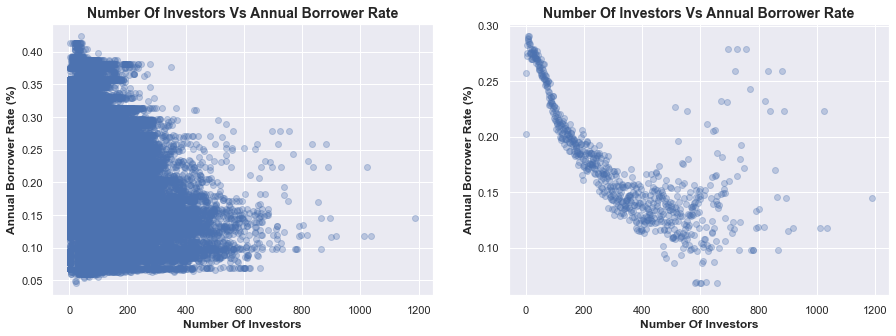

In [34]:
plt.figure(figsize=[15, 5])

plt.subplot(1, 2, 1)
plt.scatter(data=clean_pisa, y='BorrowerAPR', x='Investors', alpha=0.3)
mylabels('number of investors vs Annual Borrower rate','number of investors', 'Annual Borrower Rate (%)');

plt.subplot(1, 2, 2)
inv = clean_pisa.groupby('Investors', as_index=False)['BorrowerAPR'].mean()
plt.scatter(data=inv, x='Investors', y='BorrowerAPR', alpha=0.3)
mylabels('number of investors vs Annual Borrower rate','number of investors', 'Annual Borrower Rate (%)');

The correlation is clearer in the second plot that the more the investors the lesser the rate a string negative correlation, but as the number passes 600 the trend seems to scatter out, but this is useful

### Time vs. Rate
Checking the rate against the time

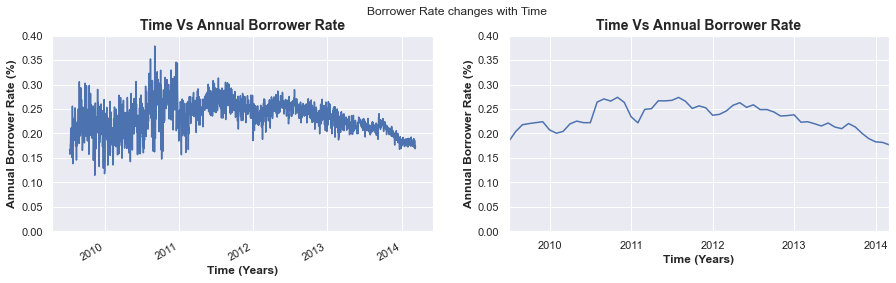

In [35]:
plt.figure(figsize=[15, 4])
plt.suptitle('Borrower Rate changes with Time')

plt.subplot(1, 2, 1)
clean_pisa.groupby('ListingCreationDate')['BorrowerAPR'].mean().plot(kind='line')
mylabels('Time vs Annual Borrower rate','time (Years)', 'Annual Borrower Rate (%)');
plt.ylim(0, 0.4)

plt.subplot(1, 2, 2)
clean_pisa['year_month']=clean_pisa['ListingCreationDate'].dt.to_period('M')
clean_pisa.groupby('year_month')['BorrowerAPR'].mean().plot(kind='line')
mylabels('Time vs Annual Borrower rate','time (Years)', 'Annual Borrower Rate (%)');
plt.ylim(0, 0.4);

The chart to the left is too noisy, so i plotted the monthly mean, and we can see the rate peaked at late 2010 and mid-2011, and has been dropping ever since. The rates are on a decline thats interesting.

### Employment, Income and Rate
Going to look into how the income and employment related features, including credit score affects rate

Starting with income: How does income affect the Borrower Rate?

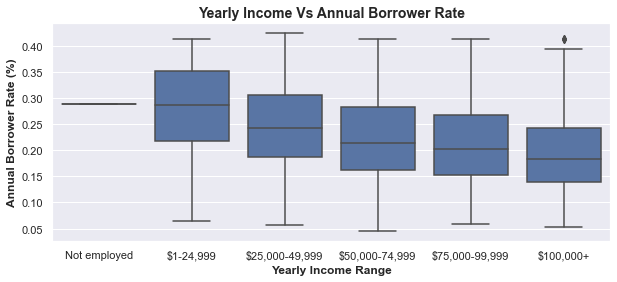

In [36]:
plt.figure(figsize=[10, 4])

sns.boxplot(data=clean_pisa, x='IncomeRange', y='BorrowerAPR', color=default_color)
mylabels('Yearly income vs Annual Borrower rate','yearly income range', 'Annual Borrower Rate (%)');

The rate median drops as the income increases, negative correlation, the higher the income the lower the rate.

Checking how occupation correlates with the Borrower Rate.

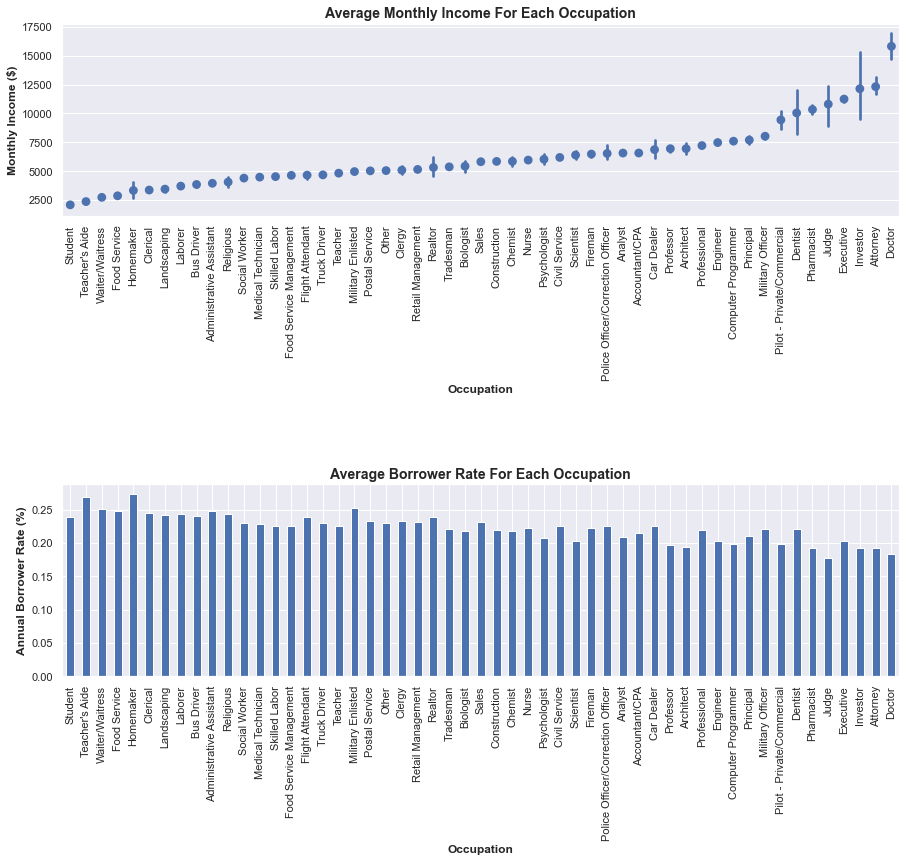

In [37]:
plt.figure(figsize=[15, 12])

occupation_df = clean_pisa.groupby('Occupation', as_index=False)[['StatedMonthlyIncome','BorrowerAPR', 'Occupation']].mean()
occupation_df = occupation_df.sort_values('StatedMonthlyIncome')

plt.subplot(3, 1, 1)
# occupation_df.set_index('Occupation').StatedMonthlyIncome.plot(kind='bar',
#                                                                   title='Average Monthly Income for each  Occupation')
sns.pointplot(data=clean_pisa, y='StatedMonthlyIncome', x='Occupation', 
              linestyles = '', dodge = 0.4, order=occupation_df.Occupation)
plt.xticks(rotation=90)
mylabels('average monthly income for each occupation','Occupation', 'Monthly Income ($)');

plt.subplot(3, 1, 3)
occupation_df.set_index('Occupation').BorrowerAPR.plot(kind='bar',
                            title='Average Annual Borrower Rate for each  Occupation')
plt.ylabel('Annual Borrower Rate (%)');
mylabels('average borrower rate for each occupation','Occupation', 'Annual Borrower Rate (%)');

Well comparing Each occupation and their average monthly income, Doctors are top earners with close to 16k monthly average, no surprise, followed by Attorneys and Investors. The lower end occupying the students, teachers aides and waiters, earning averagely 2000.

The plot below shows the average Rate for each occupation, sorted using the monthly income and we see a steady decline in the rate, from here we can see a bit of linear negative correlation.

Checking the loan related faetures: Loan amount, Payment 

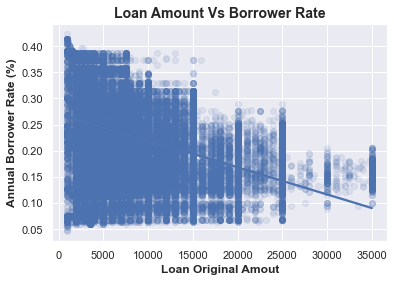

In [38]:
sns.regplot(data=clean_pisa, x='LoanOriginalAmount', y='BorrowerAPR', scatter_kws={'alpha':0.1})
mylabels('Loan amount vs Borrower Rate','Loan Original Amout', 'Annual Borrower Rate (%)');

The data points are a lot,so I will create a cetgorical feature

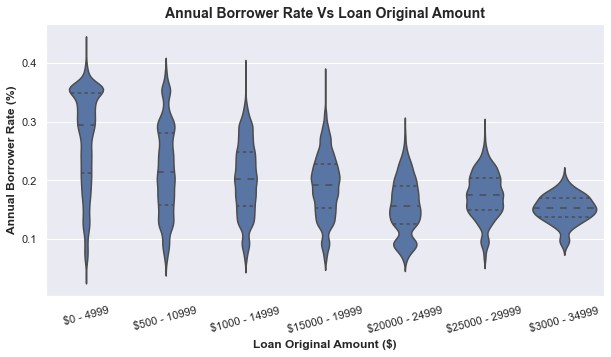

In [39]:
# The bins for the feature using the pd.cut

label = ['$0 - 4999',
         '$500 - 10999',
         '$1000 - 14999',
         '$15000 - 19999',
         '$20000 - 24999',
         '$25000 - 29999', 
         '$3000 - 34999'
        ]

clean_pisa['loanamount_cat'] = pd.cut(clean_pisa['LoanOriginalAmount'], 
                                      bins=np.arange(0, 35000+5000, 5000), 
                                      labels=label, 
                                      right=False)
loan_cat = pd.api.types.CategoricalDtype(ordered=True, categories=label)
clean_pisa['loanamount_cat'] = clean_pisa['loanamount_cat'].astype(loan_cat)

plt.figure(figsize=[10, 5])
myViolinplot(clean_pisa, 'loanamount_cat', 'BorrowerAPR', 
             xname='Loan Original Amount ($)', yname='Annual Borrower Rate (%)')
plt.xticks(rotation=15);


The steady decline in Borrower Annual Rate as the loan amount increases is now really clear

<AxesSubplot:xlabel='MonthlyLoanPayment', ylabel='BorrowerAPR'>

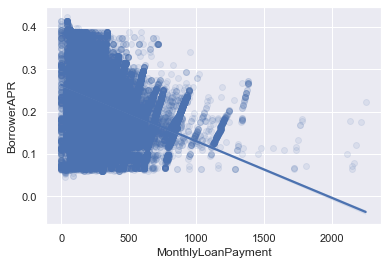

In [40]:
sns.regplot(data=clean_pisa, x='MonthlyLoanPayment', y='BorrowerAPR', scatter_kws={'alpha':0.1})

Also too noisy, I will create categorical view

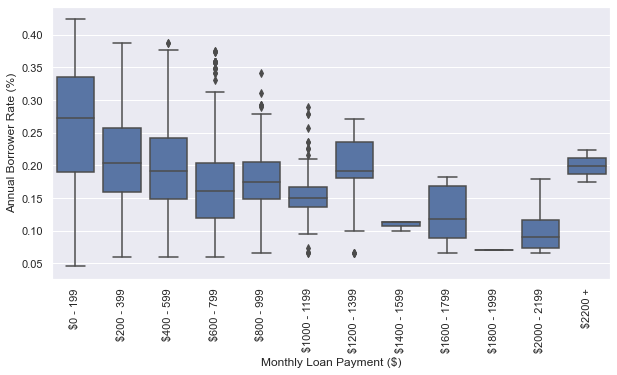

In [41]:
label = [
 '$0 - 199',
 '$200 - 399', 
 '$400 - 599', 
 '$600 - 799', 
 '$800 - 999', 
 '$1000 - 1199', 
 '$1200 - 1399', 
 '$1400 - 1599', 
 '$1600 - 1799', 
 '$1800 - 1999',
 '$2000 - 2199',
 '$2200 +' 
]
clean_pisa['loanpay_cat'] = pd.cut(clean_pisa['MonthlyLoanPayment'], bins=np.arange(0, 2400+200, 200), right=False, 
                                   labels=label)

loanpay_cat = pd.api.types.CategoricalDtype(ordered=True, categories=label)
clean_pisa['loanpay_cat'] = clean_pisa['loanpay_cat'].astype(loanpay_cat)

plt.figure(figsize=[10, 5])
sns.boxplot(data=clean_pisa, x='loanpay_cat', y='BorrowerAPR', color=default_color)
plt.xticks(rotation=90)
plt.ylabel('Annual Borrower Rate (%)')
plt.xlabel('Monthly Loan Payment ($)');

The range of the borrower rate is seen to reduce as the monthly payment increases. The median also drops as increase in the rate.

<AxesSubplot:xlabel='MonthlyLoanPayment', ylabel='LoanOriginalAmount'>

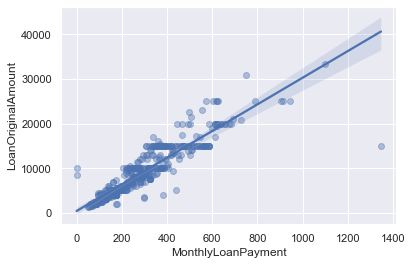

In [42]:
sns.regplot(data=clean_pisa_samp, x='MonthlyLoanPayment', y='LoanOriginalAmount', scatter_kws={'alpha':0.4})

The loan Payment and the loan amount has a strong postive correlation, this is definitely why the trend for the Borrower rate for each is similar.

Looking into the monthly loan payment and the monthly income

<AxesSubplot:xlabel='MonthlyLoanPayment', ylabel='StatedMonthlyIncome'>

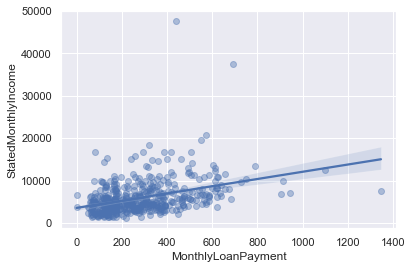

In [43]:
sns.regplot(data=clean_pisa_samp, x='MonthlyLoanPayment', y='StatedMonthlyIncome', scatter_kws={'alpha':0.4})

<AxesSubplot:xlabel='DebtToIncomeRatio', ylabel='BorrowerAPR'>

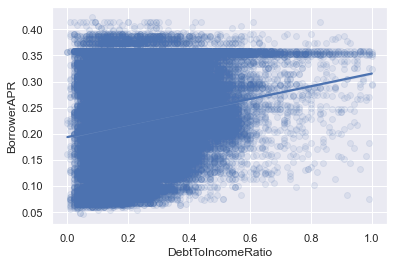

In [44]:
sns.regplot(data=clean_pisa[clean_pisa['DebtToIncomeRatio'] <= 1], x='DebtToIncomeRatio', y='BorrowerAPR', 
            scatter_kws={'alpha':0.1})

Nothing too clear here, so moving on to checking the relationship of debt-to-income ratio with the income range

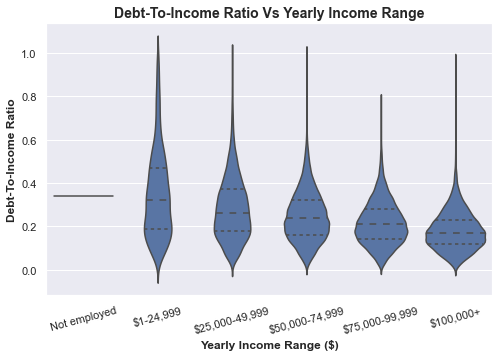

In [45]:
plt.figure(figsize=[8, 5])
myViolinplot(clean_pisa[clean_pisa['DebtToIncomeRatio'] <= 1], yVar='DebtToIncomeRatio', xVar='IncomeRange', 
            yname='Debt-to-Income ratio', xname='Yearly Income Range ($)')
plt.xticks(rotation=15);

It is really evident that people with higher income tend to have lower debt to income ratio 

### Credit score Average

How does the Borrower Rate vary with credit score?

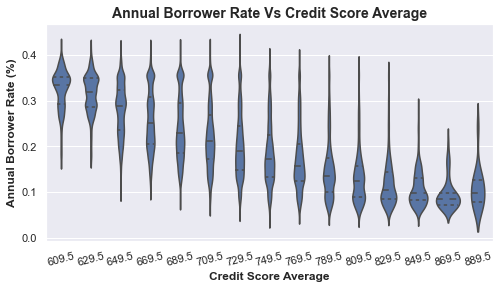

In [46]:
plt.figure(figsize=[8, 4])
myViolinplot(clean_pisa, xVar='CreditScoreAverage', yVar='BorrowerAPR',
             yname='Annual Borrower Rate (%)', xname='Credit Score Average')
plt.xticks(rotation=15);

It is really clear that the BorrowerAPR is stronly correlated to the credit score average,

Let's see how the average is in relation with the Monthly income

<AxesSubplot:xlabel='IncomeRange', ylabel='CreditScoreAverage'>

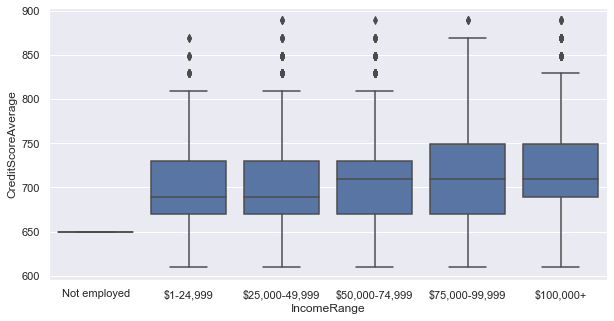

In [47]:
plt.figure(figsize=[10, 5])
sns.boxplot(data=clean_pisa, x='IncomeRange', y='CreditScoreAverage', color=default_color)

As expected the averge credit score increases as the the income range increases.

### The Listing category

How does the Rate vary with the Listing category?

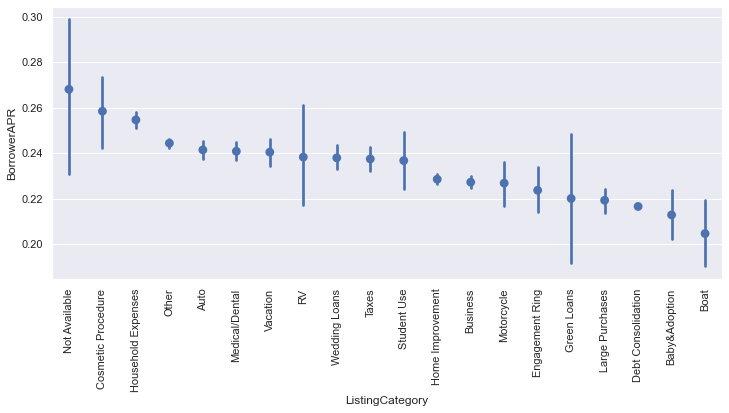

In [48]:
listcat = clean_pisa.groupby('ListingCategory', 
                   as_index=False).mean()[['BorrowerAPR', 'ListingCategory']].sort_values('BorrowerAPR', ascending=False)

listcat.ListingCategory

plt.figure(figsize=[12, 5])
sns.pointplot(data=clean_pisa, y='BorrowerAPR', x='ListingCategory', 
            order=listcat.ListingCategory, linestyles = '',
            color=default_color)
plt.xticks(rotation=90);

Cosmetics having the highest rates, and Boats on the low rate side. It seems the low risk loans have lesser interest, because boats are assets.

### Home Owners

<AxesSubplot:xlabel='IsBorrowerHomeowner', ylabel='BorrowerAPR'>

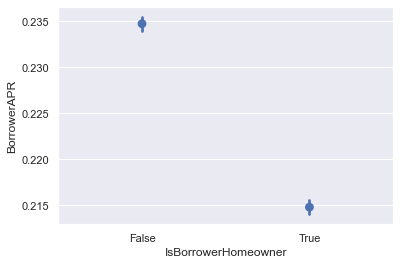

In [49]:
sns.pointplot(data=clean_pisa, y='BorrowerAPR', x='IsBorrowerHomeowner', 
              linestyles = '', color=default_color)


Well Home owners have lower Rate averagely, that good very interesting.

<AxesSubplot:xlabel='IsBorrowerHomeowner', ylabel='ProsperScore'>

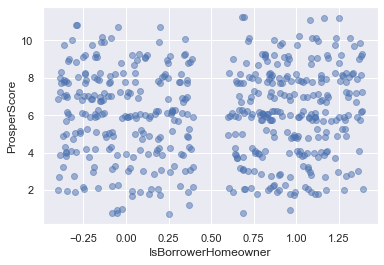

In [50]:
sns.regplot(fit_reg=False, data=clean_pisa_samp, y='ProsperScore', x='IsBorrowerHomeowner',
            x_jitter=0.4, y_jitter=0.3, scatter_kws={'alpha':0.5})

Nothin clear about home owners and the prosper score

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Borrrower Rate had a high correlation(negative) with the Prosper Score, which of course is not surprising the score must be assigned based on a metric which i can is alright. The Borrower Rate has been dropping as the years go by also very interesting to note.

The number of investors on a particular loan was also highly correlated with the Borrower Rate, the more the investors, the lower the rate as it shows, obviously investors wouldn't  invest in high risk loans but we will have to check that.

The income range also showed a negative relationship with the Rate, although the stated monthly income wasn't that highly correlated with the Rate. The average Rate for each occupation was seen and the occupation with the highest income seems to have the lowest rates, this will be investigated further.

The loan amount taken also affected the rate greatly, drawing a violin plot showed that rate dropped as the loan amount increased( I had to create a categorical view of the loan amount to present this clearly). The monthly payment also had a negative correlation with  the price, this was also expected, as the monthly payment correlated greatly with the loan original amount obviously. 

The credit score average also showed a strong negative correlation with the Rate. The score was also positively correlated with the income range which was also to be expected.

The listing category didn't reveal much, but some categories on a average had lesser Average Borrower Rate

The Home owners also had lesser Rates, less risk I suppose.


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

The debt-to-income ratio and Rate didn't show any obvious relationship as i though it would, but checking the ratio with the categorical income range, the higher the income range the lesser the ratio, unfortunately people with less income have higher debts to pay.That's sad.

The Home owners against the Prosper Score didn't give any obvious insight against my inital thoughts.

## Multivariate Exploration

The main thing would be to see how Home owners affect the rating against other features, and also to see how the prosper rating  comes into play.

Comparing the time line of home owners and non-home owners with the rate

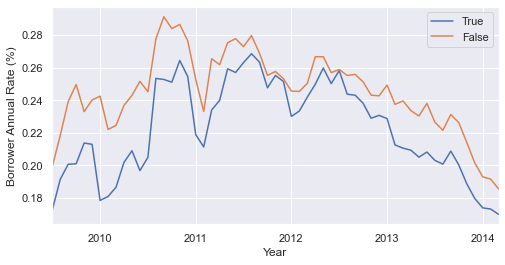

In [51]:
plt.figure(figsize=[8, 4])
clean_pisa.query('IsBorrowerHomeowner == True').groupby('year_month')['BorrowerAPR'].mean().plot(kind='line')
clean_pisa.query('IsBorrowerHomeowner == False').groupby('year_month')['BorrowerAPR'].mean().plot(kind='line')
plt.legend(['True', 'False'])
plt.ylabel('Borrower Annual Rate (%)')
plt.xlabel('Year');

Very clear as it shows that over the years, the rates for home owners are lower than those without homes. So definitely having a home reduces your rate.

Checking the home owners in the income ranges too:

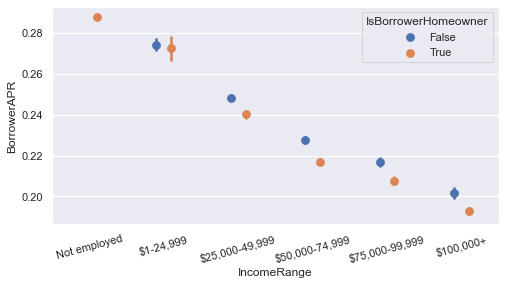

In [52]:
plt.figure(figsize=[8, 4])
sns.pointplot(data=clean_pisa, y='BorrowerAPR', x='IncomeRange', hue='IsBorrowerHomeowner', linestyles="",
              dodge=0.2)
plt.xticks(rotation=15);

The home owners have lower rates overall, even comparing it within each income range this trend is really clear.

### Investors , Rate, Prosper Score

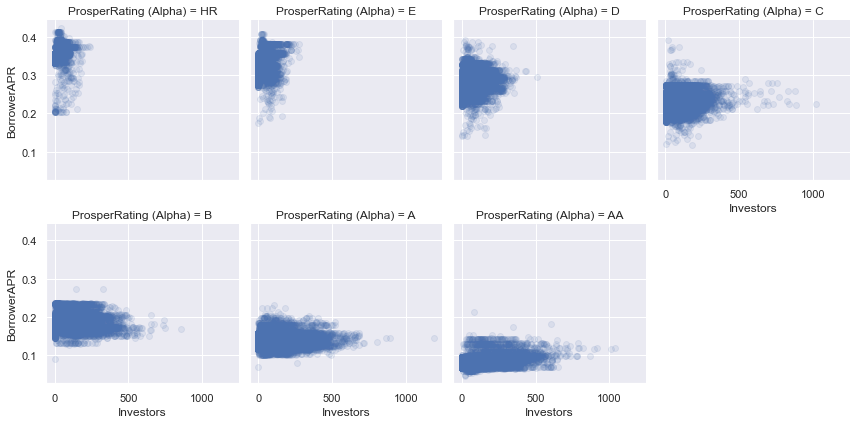

In [53]:
g = sns.FacetGrid(data = clean_pisa, col = 'ProsperRating (Alpha)', col_wrap= 4)

g.map(plt.scatter, 'Investors', 'BorrowerAPR', alpha=0.1);
# sns.regplot(data=clean_pisa_samp, y='BorrowerAPR', x='Investors', hue='ProsperScore');
# plt.xticks(rotation=15);

The drop in Rate is really as the Rating increases (from HR - AA). Also to note the rating for those with more number of investors were higher, and the rate drops with the invrease in rating and number of investors.

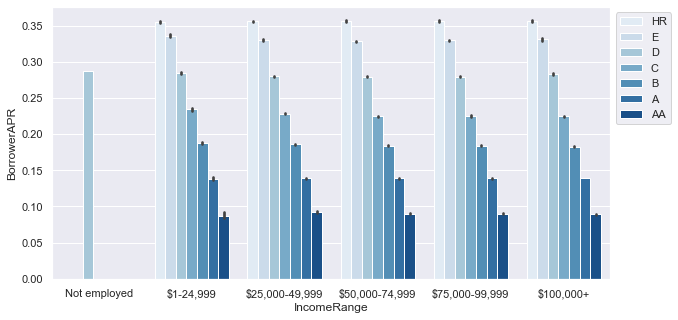

In [54]:
plt.figure(figsize=[10, 5])
sns.barplot(data = clean_pisa, x = 'IncomeRange', y='BorrowerAPR', hue = 'ProsperRating (Alpha)', palette = 'Blues')
plt.legend(bbox_to_anchor=(1, 1))

The Borrower Rate also seen to drop in each category as the rating increases, the trend is so similar for all the various income ranges.

Using the occupation average income and plotting it againdt the Borrower Rate


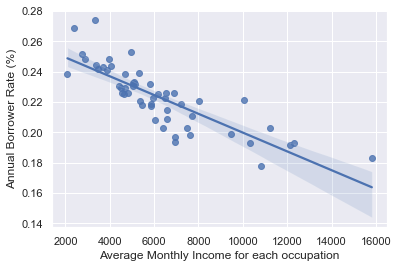

In [55]:
sns.regplot(data=occupation_df, y='BorrowerAPR', x='StatedMonthlyIncome')
plt.ylabel('Annual Borrower Rate (%)')
plt.xlabel('Average Monthly Income for each occupation');

Building on the occupation subset, plotting a scatter plot of monthly income of each occupation with the Borrower Rate. The relationship is very strong.

Checking the listing categories in each income Range to see how it affects the Rate.

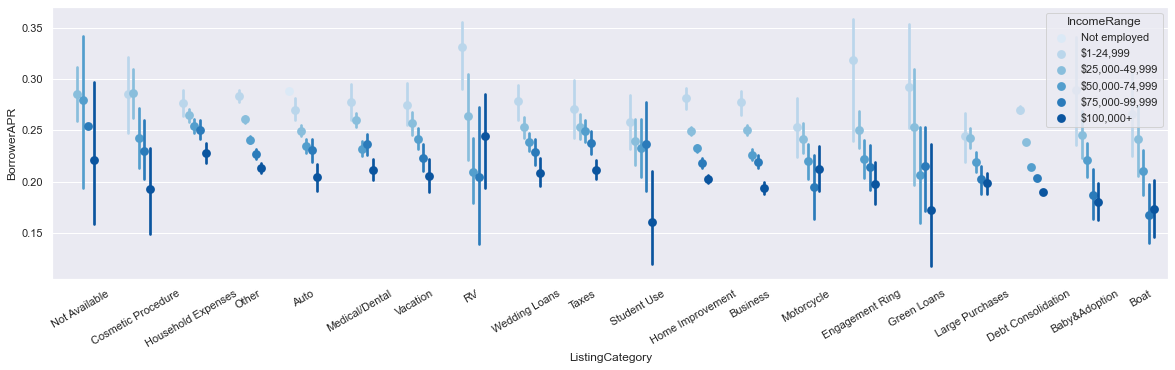

In [56]:
plt.figure(figsize=[20, 5])
sns.pointplot(data=clean_pisa, x='ListingCategory', y='BorrowerAPR', hue='IncomeRange',
              order=listcat.ListingCategory, dodge=0.5, linestyles="", palette='Blues')
plt.xticks(rotation=30);

Income ranges for each listing category, is like the deciding factor for the Borrower Rating. Income Range is a strong feature for determining the rate

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

Building on the homeowner feature, comparing this with the time (Year) and the Borrower Rate, home owners have lower rates over the Years than those without home. Further checking the strength of having a home by checking it against the Rate after subsetting it by income Range, home owners had lower rates than their countrparts in each category of income range.

The Prosper Rating also greatly affects the borrower rate and also the number of investors too, as we see the better the rating the more the investors and the lower the Rate.

Checking each listing with the income range against the Rate, shows that the income range also negatively affects the Rate

### Were there any interesting or surprising interactions between features?

The average rate for each income range when categorised by  the Prosper Rating was exactly the same, I think the Rating affects the Borrower Rate more than the Income Range

## Conclusions

The Borrower Rate for loans are greatly dependent on the  income range and the loan amount taken, but all this also have a strong relationship with the prosper ratings given at the time of listing.

To get better Annual Rate, have assets the are low risk, like a home, as it always guarantees a lower rate.

In [57]:
clean_pisa.to_csv('prosper_loan.csv', index=False)